Example of building a new `ws3` model from scratch.

In [171]:
import pandas as pd
import geopandas as gpd

import ws3.forest, ws3.core

In [172]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 999
tvy_name = 'totvol'

Now populate `fm` with data.

Create a new blank `ForestModel` instance.

# Build a ws3 model from Woodstock-format text input files

`ws3` has built-in functions that can parse Woodstock-formatted model definition text files. Here we build an equivalent model to above, but using Woodstock-foratted text files (as an alternative to the pure Python code implementation above).

Start by creating a new directory to hold the model definition files.

Woodstock models are defined in terms of a number of _sections_. The sections can be defined in a single text file, or in separate text files. We will use separate text files for each section in this example.

Our model will include the following sections:

LANDSCAPE
AREAS
YIELD
ACTIONS
TRANSITIONS

There are other possible sections that one can include in a Woodstock model, which will not include here. This is not intended to be a comprehensive overview of Woodstock-format model definition. Refer to the Woodstock technical documentation for the complete story.

## Create and run `ForestModel` instance

In [173]:
fm = ws3.forest.ForestModel(model_name='tsa24_clipped',
                            model_path='data/woodstock_model_files2',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)

In [174]:
fm.import_landscape_section()

In [175]:
fm.import_areas_section()

0

In [176]:
fm.import_yields_section()

('?', '?', '?', '?', '?') 2
('?', '?', '2401002', '?', '2401002') 1
('?', '?', '2401002', '?', '2401002f50o') 0
('?', '?', '2401002', '?', '2401002f50t') 0
('?', '?', '2402002', '?', '2402002') 1
('?', '?', '2402002', '?', '2402002f50o') 0
('?', '?', '2402002', '?', '2402002f50t') 0


In [177]:
fm.import_actions_section()

In [178]:
fm.import_transitions_section()

In [179]:
fm.initialize_areas()
fm.reset_actions()

In [180]:
class GreedyAreaSelector:
    """
    Default AreaSelector implementation. Selects areas for treatment from oldest age classes.
    """
    def __init__(self, parent):
        self.parent = parent

    def operate(self, period, acode, target_area, mask=None,
                commit_actions=True, verbose=False):
        """
        Greedily operate on oldest operable age classes.
        Returns missing area (i.e., difference between target and operated areas).
        """
        key = lambda item: max(item[1])
        odt = sorted(list(self.parent.operable_dtypes(acode, period, mask).items()), key=key)
        print(' entering selector.operate()', len(odt), 'operable dtypes')
        while target_area > 0 and odt:
            while target_area > 0 and odt:
                popped = odt.pop()
                try:
                    dtk, ages = popped #odt.pop()
                except:
                    print(odt)
                    print(popped)
                    raise
                age = sorted(ages)[-1]
                oa = self.parent.dtypes[dtk].operable_area(acode, period, age)
                if not oa: continue # nothing to operate
                area = min(oa, target_area)
                target_area -= area
                if area < 0:
                    print('negative area', area, oa, target_area, acode, period, age)
                    assert False
                if verbose:
                    print(' selector found area', [' '.join(dtk)], acode, period, age, area)
                self.parent.apply_action(dtk, acode, period, age, area, 
                                         fuzzy_age=False, recourse_enabled=False, 
                                         compile_c_ycomps=True, verbose=verbose)
            odt = sorted(list(self.parent.operable_dtypes(acode, period, mask).items()), key=key)
        self.parent.commit_actions(period, repair_future_actions=True)
        if verbose:
            print('GreedyAreaSelector.operate done (remaining target_area: %0.1f)' % target_area)
        return target_area

In [181]:
fm.areaselector = GreedyAreaSelector(fm)

In [182]:
# copy function definition for debugging
def schedule_harvest_areacontrol(fm, period=1, acode='cc', util=0.85, 
                                 target_masks=None, target_areas=None, target_scalefactors=None,
                                 mask_area_thresh=0.,
                                 verbose=0):
    #fm.reset_actions()
    if not target_areas:
        if not target_masks: # default to AU-wise THLB 
            au_vals = []
            au_agg = []
            for au in fm.theme_basecodes(2):
                mask = '? 1 %s ? ?' % au
                masked_area = fm.inventory(0, mask=mask)
                #print(mask, masked_area)
                if masked_area > mask_area_thresh:
                    #print(masked_area, mask_area_thresh)
                    au_vals.append(au)
                else:
                    au_agg.append(au)
                    if verbose > 0:
                        print('adding to au_agg', mask, masked_area)
                #print(au_vals)
            if au_agg:
                fm._themes[2]['areacontrol_au_agg'] = au_agg 
                if fm.inventory(0, mask='? ? areacontrol_au_agg ? ?') > mask_area_thresh:
                    au_vals.append('areacontrol_au_agg')
            target_masks = ['? 1 %s ? ?' % au for au in au_vals]
            #print(au_vals)
            #print(target_masks)
        print(target_masks, au_vals)
        #assert False
        target_areas = []
        for i, mask in enumerate(target_masks): # compute area-weighted mean CMAI age for each masked DT set
            masked_area = fm.inventory(0, mask=mask, verbose=verbose)
            if not masked_area: continue
            r = sum((fm.dtypes[dtk].ycomp('totvol').mai().ytp().lookup(0) * fm.dtypes[dtk].area(0)) for dtk in fm.unmask(mask))
            r /= masked_area
            #awr = []
            #dtype_keys = fm.unmask(mask)
            #for dtk in dtype_keys:
            #    dt = fm.dtypes[dtk]
            #    awr.append(dt.ycomp('totvol').mai().ytp().lookup(0) * dt.area(0))
            #r = sum(awr)  / masked_area
            asf = 1. if not target_scalefactors else target_scalefactors[i]  
            print(i)
            print(mask)
            print(masked_area)
            ta = (1/r) * fm.period_length * masked_area * asf
            target_areas.append(ta)
    for mask, target_area in zip(target_masks, target_areas):
        if verbose > 0:
            print('calling areaselector', period, acode, target_area, mask)
        fm.areaselector.operate(period, acode, target_area, mask=mask, verbose=verbose)
    sch = fm.compile_schedule()
    return sch

In [183]:
schedule_harvest_areacontrol(fm, period=1, verbose=1)

['? 1 2401002 ? ?', '? 1 2402002 ? ?'] ['2401002', '2402002']
0
? 1 2401002 ? ?
100.0
1
? 1 2402002 ? ?
100.0
calling areaselector 1 cc 9.70873786407767 ? 1 2401002 ? ?
 entering selector.operate() 1 operable dtypes
 selector found area ['tsa24_clipped 1 2401002 204 2401002'] cc 1 40 9.70873786407767
GreedyAreaSelector.operate done (remaining target_area: 0.0)
calling areaselector 1 cc 11.363636363636365 ? 1 2402002 ? ?
 entering selector.operate() 1 operable dtypes
 selector found area ['tsa24_clipped 1 2402002 204 2402002'] cc 1 50 11.363636363636365
GreedyAreaSelector.operate done (remaining target_area: 0.0)


[(('tsa24_clipped', '1', '2401002', '204', '2401002'),
  40,
  9.70873786407767,
  'cc',
  1,
  '_existing'),
 (('tsa24_clipped', '1', '2402002', '204', '2402002'),
  50,
  11.363636363636365,
  'cc',
  1,
  '_existing')]

In [184]:
for period in fm.periods:
    schedule_harvest_areacontrol(fm, period=period, verbose=1)

['? 1 2401002 ? ?', '? 1 2402002 ? ?'] ['2401002', '2402002']
0
? 1 2401002 ? ?
100.0
1
? 1 2402002 ? ?
100.0
calling areaselector 1 cc 9.70873786407767 ? 1 2401002 ? ?
 entering selector.operate() 1 operable dtypes
 selector found area ['tsa24_clipped 1 2401002 204 2401002'] cc 1 40 9.70873786407767
GreedyAreaSelector.operate done (remaining target_area: 0.0)
calling areaselector 1 cc 11.363636363636365 ? 1 2402002 ? ?
 entering selector.operate() 1 operable dtypes
 selector found area ['tsa24_clipped 1 2402002 204 2402002'] cc 1 50 11.363636363636365
GreedyAreaSelector.operate done (remaining target_area: 0.0)
['? 1 2401002 ? ?', '? 1 2402002 ? ?'] ['2401002', '2402002']
0
? 1 2401002 ? ?
100.0
1
? 1 2402002 ? ?
100.0
calling areaselector 2 cc 9.70873786407767 ? 1 2401002 ? ?
 entering selector.operate() 1 operable dtypes
 selector found area ['tsa24_clipped 1 2401002 204 2401002'] cc 2 41 9.70873786407767
GreedyAreaSelector.operate done (remaining target_area: 0.0)
calling areaselec

In [185]:
pareas = [fm.compile_product(period, '1.') for period in fm.periods]

In [186]:
pvols = [fm.compile_product(period, 'totvol') for period in fm.periods]

In [187]:
df = pd.DataFrame({'period':fm.periods, 'areas':pareas, 'vols':pvols})
df

,period,areas,vols
0,1,42.144748,2196.601942
1,2,21.072374,1140.445719
2,3,21.072374,1172.881730
3,4,21.072374,1215.026478
4,5,21.072374,1258.826125
5,6,21.072374,1300.970874
6,7,21.072374,1333.406884
7,8,18.799647,1166.460724
8,9,9.708738,339.805825
9,10,2.912621,107.766990


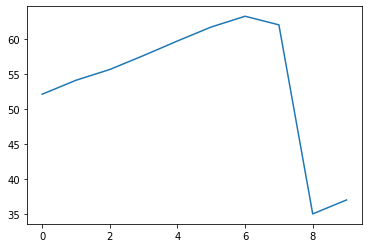

In [188]:
(df.vols/df.areas).plot()